**Import the dependencies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import pickle

**Preprocessing**

In [2]:
# load the dataset
df = pd.read_csv('/content/covtype.csv')

In [3]:
df.shape

(581012, 55)

In [4]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [6]:
# check for missing values
df.isnull().sum()

,0
Elevation,0
Aspect,0
Slope,0
Horizontal_Distance_To_Hydrology,0
Vertical_Distance_To_Hydrology,0
Horizontal_Distance_To_Roadways,0
Hillshade_9am,0
Hillshade_Noon,0
Hillshade_3pm,0
Horizontal_Distance_To_Fire_Points,0


In [7]:
# check for highly correlated columns
corr = df.corr().abs()

In [8]:
# list highly correlated columns (r>0.9)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
print("Columns to drop:", to_drop)

Columns to drop: []


In [9]:
# print cover type unique values
df['Cover_Type'].unique()

array([5, 2, 1, 7, 3, 6, 4])

In [10]:
# remap cover type values to meet the GridSearchCV requirements (values should start from 0 instead of 1)
df['Cover_Type'] = df['Cover_Type'] - 1

In [11]:
df['Cover_Type'].unique()

array([4, 1, 0, 6, 2, 5, 3])

**Split the dataset into training and testing sets**

In [12]:
# split features and target as X and y
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

In [13]:
# splitting the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model training**

In [14]:
# model training
model = XGBClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    "reg_lambda": [1.0, 2.0],
}

In [15]:
# hypertuning and fitting
grid_search = RandomizedSearchCV(model, param_grid, n_iter=12, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [6, 8],
                                        'n_estimators': [100, 200],
                                        'reg_lambda': [1.0, 2.0],
                                        'subsample': [0.8, 1.0]},
                   scoring='accuracy', verbose=1)

In [16]:
# best model parameters
best_model = grid_search.best_estimator_
print("Best Model Parameters:", grid_search.best_params_)

Best Model Parameters: {'subsample': 0.8, 'reg_lambda': 2.0, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1}


**Model evaluation**

In [17]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.89744219 0.89613776 0.89815795]
Mean CV Score: 0.8972459651249846


In [18]:
# test set performance
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.8994518213815478
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88     42557
           1       0.89      0.92      0.91     56500
           2       0.93      0.94      0.93      7121
           3       0.93      0.86      0.89       526
           4       0.92      0.66      0.77      1995
           5       0.89      0.87      0.88      3489
           6       0.95      0.94      0.95      4015

    accuracy                           0.90    116203
   macro avg       0.91      0.87      0.89    116203
weighted avg       0.90      0.90      0.90    116203

Confusion Matrix:
 [[37030  5356     1     0    14     2   154]
 [ 3899 52232   134     1   104   105    25]
 [    0   169  6681    22     1   248     0]
 [    0     0    57   450     0    19     0]
 [   27   616    28     0  1315     9     0]
 [    2   152   298    13     2  3022     0]
 [  206    19     0     0     1     0  3789]]


In [19]:
# feature importance
feature_importance = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", feature_importance_df)

Feature Importance:
                                Feature  Importance
0                            Elevation    0.080168
35                         Soil_Type22    0.053797
10                    Wilderness_Area1    0.053144
15                          Soil_Type2    0.047014
45                         Soil_Type32    0.041646
25                         Soil_Type12    0.041616
17                          Soil_Type4    0.041333
52                         Soil_Type39    0.041152
12                    Wilderness_Area3    0.029993
11                    Wilderness_Area2    0.029276
51                         Soil_Type38    0.029032
36                         Soil_Type23    0.026377
42                         Soil_Type29    0.025556
16                          Soil_Type3    0.025427
44                         Soil_Type31    0.023167
13                    Wilderness_Area4    0.023148
34                         Soil_Type21    0.021058
48                         Soil_Type35    0.019460
43        

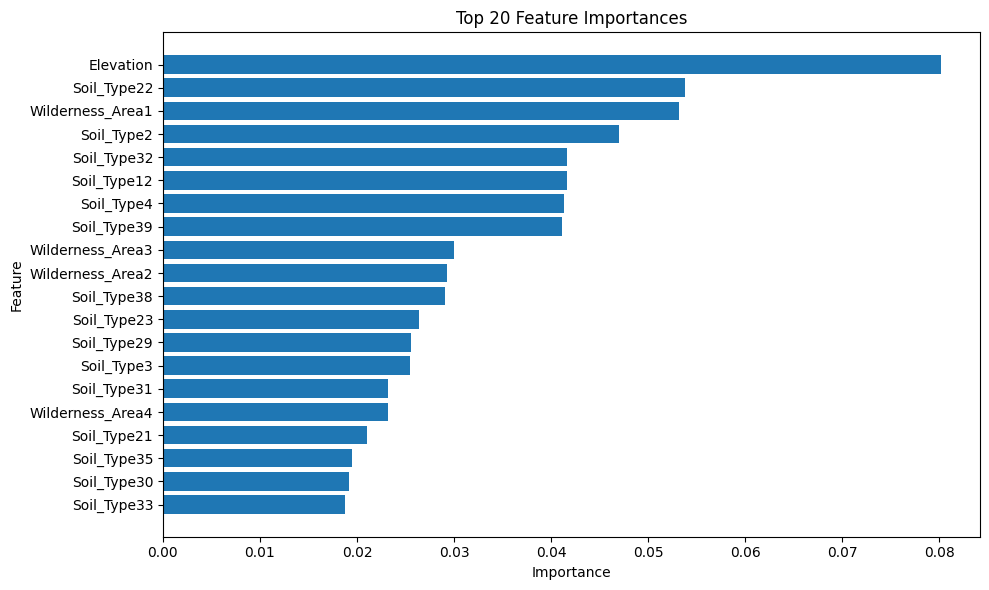

In [25]:
# plot feature importance (20 most important)
k = min(20, len(feature_importance_df))
topk = feature_importance_df.head(k)

topk_for_plot = topk.iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(topk_for_plot["Feature"], topk_for_plot["Importance"], align="center")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f"Top {k} Feature Importances")
plt.tight_layout()
plt.show()